# Week 7 - Information Extraction


This week, we move from arbitrary textual classification to the use of computation and linguistic models to parse precise claims from documents. Rather than focusing on simply the *ideas* in a corpus, here we focus on understanding and extracting its precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases, like the Subject-Verb-Object (SVO) triples we extract here. While much of this can be done directly in the python package NLTK that we introduced in week 2, here we use NLTK bindings to the Stanford NLP group's open software, written in Java. Try typing a sentence into the online version [here](http://nlp.stanford.edu:8080/corenlp/) to get a sense of its potential. It is superior in performance to NLTK's implementations, but takes time to run, and so for these exercises we will parse and extract information for a very small text corpus. Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
#For NLP
import nltk

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

%matplotlib inline

You need to run this _once_ to download everything, you will also need [Java 1.8+](http://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html) if you are using Windows or MacOS.

In [ ]:
lucem_illud.setupStanfordNLP()

We need to have stanford-NLP setup before importing, so we are doing the import here. IF you have stanford-NLP working, you can import at the beginning like you would with any other library.

In [2]:
import lucem_illud.stanford as stanford

/usr/local/lib/python3.6/site-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)
/usr/local/lib/python3.6/site-packages/nltk/tag/stanford.py:149: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordPOSTagger, self).__init__(*args, **kwargs)


Open Information Extraction is a module packaged within the Stanford Core NLP package, but it is not yet supported by `nltk`. As a result, we have defining our own `lucem_illud` function that runs the Stanford Core NLP java code right here. For other projects, it is often useful to use Java or other programs (in C, C++) within a python workflow, and this is an example. `stanford.openIE()` takes in a string or list of strings and then produces as output all the subject, verb, object (SVO) triples Stanford Corenlp can find, as a DataFrame. You can do this through links to the Stanford Core NLP project that we provide here, or play with their interface directly (in the penultimate cell of this notebook), which produces data in "pretty graphics" like this example parsing of the first sentence in the "Shooting of Trayvon Martin" Wikipedia article:

![Output 1](../data/stanford_core1.png)
![Output 2](../data/stanford_core2.png)

First, we will illustrate these tools on some *very* short examples:

In [ ]:
text = ['I saw the elephant in my pajamas.', 'The quick brown fox jumped over the lazy dog.', 'While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.', 'Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.', 'Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo']
tokenized_text = [nltk.word_tokenize(t) for t in text]
print('\n'.join(text))

# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. The Stanford POS tagger uses the [Penn Treebank tag set]('http://repository.upenn.edu/cgi/viewcontent.cgi?article=1603&context=cis_reports') to POS tag words from input sentences. As discussed in the second assignment, this is a relatively precise tagset, which allows more informative tags, and also more opportunities to err :-).

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

In [ ]:
pos_sents = stanford.postTagger.tag_sents(tokenized_text)
print(pos_sents)

This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [ ]:
redditDF = pandas.read_csv('../data/reddit.csv', index_col=0)

Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word).

In [ ]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores[-5:]

In [ ]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))

In [ ]:
redditTopScores['POS_sents']

And count the number of `NN` (nouns)

In [ ]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

What about the number of top verbs (`VB`)?

In [ ]:
countTarget = 'VB'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

What about the adjectives that modify the word, "computer"?

In [ ]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

## Evaluating POS tagger

We can check the POS tagger by running it on a manually tagged corpus and identifying a reasonable error metric.

In [ ]:
treeBank = nltk.corpus.treebank
treeBank.tagged_sents()[0]

In [ ]:
treeBank.sents()[0]

In [ ]:
stanfordTags = stanford.postTagger.tag_sents(treeBank.sents()[:30])

And compare the two

In [ ]:
NumDiffs = 0
for sentIndex in range(len(stanfordTags)):
    for wordIndex in range(len(stanfordTags[sentIndex])):
        if stanfordTags[sentIndex][wordIndex][1] != treeBank.tagged_sents()[sentIndex][wordIndex][1]:
            if treeBank.tagged_sents()[sentIndex][wordIndex][1] != '-NONE-':
                print("Word: {}  \tStanford: {}\tTreebank: {}".format(stanfordTags[sentIndex][wordIndex][0], stanfordTags[sentIndex][wordIndex][1], treeBank.tagged_sents()[sentIndex][wordIndex][1]))
                NumDiffs += 1
total = sum([len(s) for s in stanfordTags])
print("The Precision is {:.3f}%".format((total-NumDiffs)/total * 100))

So we can see that the stanford POS tagger is quite good. Nevertheless, for a 20 word sentence, we only have a 66% chance ($1-.96^{20}$) of tagging (and later parsing) it correctly.

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional frequencies (e.g., adjectives associated with nouns of interest or adverbs with verbs of interest). What do these distributions suggest about your corpus?

In [12]:
news_df_total = pandas.read_pickle('../data/news_better.pkl')
news_df = news_df_total.sample(100)
news_df['sentences'] = news_df['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])

NameError: name 'redditTopScores' is not defined

In [13]:
news_df['POS_sents'] = news_df['sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))

In [17]:
def pos_counter(target_pos, pos_sentences):
    targetCounts = {}
    for entry in pos_sentences:
        for sentence in entry:
            for ent, kind in sentence:
                if not kind.startswith(target_pos):
                    continue
                elif ent in targetCounts:
                    targetCounts[ent] += 1
                else:
                    targetCounts[ent] = 1
    sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
    return sortedTargets

def pos_collocation_counter(target_pos, pos_sentences, target_word, pos_after=False):
    NResults = set()
    for entry in pos_sentences:
        for sentence in entry:
            for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
                if pos_after and ent2.lower()==target_word and kind1.startswith(target_pos): #(kind1,ent2.lower())==(target_pos,target_word):
                    NResults.add(ent1)
                elif not pos_after and ent1.lower()==target_word and kind2.startswith(target_pos): #(kind2, ent1.lower())==(target_pos,target_word):
                    NResults.add(ent2)
                else:
                    continue
    return NResults

In [18]:
pos_counter('NN', news_df['POS_sents'])[:20]

[('climate', 528),
 ('change', 405),
 ('countries', 158),
 ('China', 155),
 (')', 143),
 ('world', 134),
 ('(', 122),
 ('Climate', 121),
 ('s', 119),
 ('people', 110),
 ('Trump', 99),
 ('Paris', 95),
 ('”', 95),
 ('“', 91),
 ('year', 89),
 ('energy', 82),
 ('country', 81),
 ('President', 80),
 ('water', 79),
 ('US', 76)]

In [19]:
pos_collocation_counter('VB', news_df['POS_sents'], 'change')

{'affecting',
 'are',
 'became',
 'brought',
 'continue',
 'declared',
 'demands',
 'encourages',
 'featured',
 'found',
 'gained',
 'get',
 'had',
 'has',
 'hurts',
 'including',
 'increases',
 'is',
 'meet',
 'play',
 'poses',
 'presents',
 'puts',
 'requires',
 'rests',
 'results',
 'said',
 'shifted',
 'think',
 'took',
 'was'}

# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. Included with Stanford NER are a 4 class model trained on the CoNLL 2003 eng.train, a 7 class model trained on the MUC 6 and MUC 7 training data sets, and a 3 class model trained on both data sets plus some additional data (including ACE 2002 and limited data in-house) on the intersection of those class sets. 

**3 class**:	Location, Person, Organization

**4 class**:	Location, Person, Organization, Misc

**7 class**:	Location, Person, Organization, Money, Percent, Date, Time

These models each use distributional similarity features, which provide some performance gain at the cost of increasing their size and runtime. Also available are the same models missing those features.

(We note that the training data for the 3 class model does not include any material from the CoNLL eng.testa or eng.testb data sets, nor any of the MUC 6 or 7 test or devtest datasets, nor Alan Ritter's Twitter NER data, so all of these would be valid tests of its performance.)

First, we tag our first set of exemplary sentences:

In [ ]:
classified_sents = stanford.nerTagger.tag_sents(tokenized_text)
print(classified_sents)

We can also run NER over our entire corpus:

In [ ]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))

In [ ]:
redditTopScores['classified_sents']

Find the most common entities (which are, of course, boring):

In [ ]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

Or those occurring only twice:

In [ ]:
[x[0] for x in sortedEntities if x[1] == 2]

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [ ]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'O':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

What about the Organizations?

In [ ]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'ORGANIZATION':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

These, of course, have much smaller counts.

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed (using your own hand-codings as "ground truth").

In [20]:
news_df['classified_sents'] = news_df['sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))

In [22]:
def type_counter(sentences):
    dict_counts = {}
    for entry in sentences:
        for sentence in entry:
            for ent, kind in sentence:
                if kind in dict_counts:
                    dict_counts[kind] += 1
                else:
                    dict_counts[kind] = 1
    return dict_counts
type_counter(news_df['classified_sents'])

{'LOCATION': 1363, 'O': 60580, 'ORGANIZATION': 1710, 'PERSON': 1258}

In [24]:
pos_counter(pos_sentences=news_df['classified_sents'], target_pos='PERSON')[:30]

[('Trump', 94),
 ('Xi', 40),
 ('Donald', 33),
 ('Brown', 19),
 ('Howe', 18),
 ('Harvey', 16),
 ('Jinping', 14),
 ('Obama', 11),
 ('Merkel', 10),
 ('Prasad', 10),
 ('Irma', 10),
 ('Al', 9),
 ('Joseph', 9),
 ('Scott', 9),
 ('Lee', 8),
 ('Peter', 8),
 ('Shehu', 8),
 ('Glynn', 8),
 ('Barack', 7),
 ('Macron', 7),
 ('Michael', 7),
 ('Buhari', 7),
 ('Scaramucci', 7),
 ('Baker', 6),
 ('Pruitt', 6),
 ('Abbott', 6),
 ('Wang', 6),
 ('Mutua', 6),
 ('Boeve', 6),
 ('Paul', 5)]

# Parsing

Here we will introduce the Stanford Parser by feeding it tokenized text from our initial example sentences. The parser is a dependency parser, but this initial program outputs a simple, self-explanatory phrase-structure representation.

In [ ]:
parses = list(stanford.parser.parse_sents(tokenized_text)) #Converting the iterator to a list so we can call by index. They are still 
fourthSentParseTree = list(parses[3]) #iterators so be careful about re-running code, without re-running this block
print(fourthSentParseTree)

Trees are a common data structure and there are a large number of things to do with them. What we are intetered in is the relationship between different types of speech

In [ ]:
def treeRelation(parsetree, relationType, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retList = []
        for subT in parsetree.subtrees():
            if subT.label() == relationType:
                if set(targets) & set(subT.leaves()) == set(targets):
                    retList.append([(subT.label(), ' '.join(subT.leaves()))])
    return retList

In [ ]:
def treeSubRelation(parsetree, relationTypeScope, relationTypeTarget, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retSet = set()
        for subT in parsetree.subtrees():
            if set(targets) & set(subT.leaves()) == set(targets):
                if subT.label() == relationTypeScope:
                    for subsub in subT.subtrees():
                        if subsub.label()==relationTypeTarget:
                            retSet.add(' '.join(subsub.leaves()))
    return retSet

In [ ]:
treeRelation(fourthSentParseTree, 'NP', 'Florida', 'who')

Notice that Florida occurs twice in two different nested noun phrases in the sentence. 

We can also find all of the verbs within the noun phrase defined by one or more target words:

In [ ]:
treeSubRelation(fourthSentParseTree, 'NP', 'VBN', 'Florida', 'who')

Or if we want to to look at the whole tree

In [ ]:
fourthSentParseTree[0].pretty_print()

Or another sentence

In [ ]:
list(parses[1])[0].pretty_print()

## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

In [ ]:
depParses = list(stanford.depParser.raw_parse_sents(text)) #Converting the iterator to a list so we can call by index. They are still 
secondSentDepParseTree = list(depParses[1])[0] #iterators so be careful about re-running code, without re-running this block
print(secondSentDepParseTree)

This is a graph and we can convert it to a dot file and use that to visulize it. Try traversing the tree and extracting elements that are nearby one another. We note that unless you have the graphviz successfully installed on your computer (which is not necessary to complete this homework), the following graphviz call will trigger an error. If you are interested in installing graphviz and working on a Mac, consider installing through [homebrew](https://brew.sh), a package manager (i.e., with the command "brew install graphviz", once brew is installed). 

In [ ]:
try:
    secondSentGraph = graphviz.Source(secondSentDepParseTree.to_dot())
except:
    secondSentGraph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
secondSentGraph

Or another sentence 

In [ ]:
try:
    graph = graphviz.Source(list(depParses[3])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph

We can also do a dependency parse on the reddit sentences:

In [ ]:
topPostDepParse = list(stanford.depParser.parse_sents(redditTopScores['sentences'][0]))

This takes a few seconds, but now lets look at the parse tree from one of the processed sentences.

The sentence is:

In [ ]:
targetSentence = 7
print(' '.join(redditTopScores['sentences'][0][targetSentence]))

Which leads to a very rich dependancy tree:

In [ ]:
try:
    graph = graphviz.Source(list(topPostDepParse[targetSentence])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceived to play in the social world inscribed by your texts?

In [70]:
news_df['sentences_untokenized'] = news_df['text'].apply(lambda x: nltk.sent_tokenize(x))

In [98]:
news_df['parse_trees'] = news_df['sentences_untokenized'].apply(lambda x: [list(a) for a in stanford.depParser.raw_parse_sents(x)])

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.
Parsing file: /var/folders/kj/r422rjhx36sfbn0t1zn4mcdw0000gn/T/tmp285_m4ne
Parsing [sent. 1 len. 12]: Moving to a foreign country can be a very stressful experience .
Parsing [sent. 2 len. 36]: Everything is unfamiliar : the language , the customs , the climate , the food ... Sooner or later , however , most newcomers tend to adapt and settle in well in their new home .
Parsing [sent. 3 len. 10]: Some even manage to localize without even realizing it .
Parsing [sent. 4 len. 219]: All expats in Shanghai have gone through these various stages of adaptation and inculcation , and despite the city 's historic reputation as an internationally influenced metropolis and despite the occasional criticism that `` Shanghai is n't real China , '' many foreign residents here tend to `` go nati

OSError: Java command failed : ['/usr/bin/java', '-mx1000m', '-cp', '../stanford-NLP/parser/stanford-parser-3.8.0-models.jar:../stanford-NLP/parser/stanford-parser-3.8.0-models.jar:../stanford-NLP/parser/ejml-0.23.jar:../stanford-NLP/parser/slf4j-api.jar:../stanford-NLP/parser/stanford-parser-3.8.0-sources.jar:../stanford-NLP/parser/stanford-parser-3.8.0-javadoc.jar:../stanford-NLP/parser/stanford-parser.jar:../stanford-NLP/parser/slf4j-api-1.7.12-sources.jar', 'edu.stanford.nlp.parser.lexparser.LexicalizedParser', '-model', 'edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz', '-sentences', 'newline', '-outputFormat', 'conll2007', '-encoding', 'utf8', '/var/folders/kj/r422rjhx36sfbn0t1zn4mcdw0000gn/T/tmp285_m4ne']

In [90]:
#exper = list(stanford.depParser.raw_parse_sents(news_df['text'].iloc[34]))
mytext = news_df['sentences_untokenized'].iloc[34]
#mytext = 'My name is Victor and I like green pozole with cumin. My sisters are doing great things. I love them.'
exper = [list(a) for a in stanford.depParser.raw_parse_sents(mytext)]

In [96]:
dir(exper[0])

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__length_hint__',
 '__lt__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

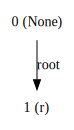

In [53]:
#print(list(list(stanford.depParser.raw_parse_sents(news_df['text'].iloc[34]))[0])[0])
graphviz.Source(list(list(stanford.depParser.raw_parse_sents(news_df['text'].iloc[34]))[1])[0].to_dot())

In [ ]:
list(stanford.depParser.parse_sents(redditTopScores['sentences'][0]))

# Information extraction

Information extraction approaches typically (as here, with Stanford's Open IE engine) ride atop the dependency parse of a sentence. They are a pre-coded example of the type analyzed in the prior. 

In [ ]:
ieDF = stanford.openIE(text)

`openIE()` prints everything stanford core produces and we can see from looking at it that initializing the dependency parser takes most of the time, so calling the function will always take at least 12 seconds.

In [ ]:
ieDF

No buffalos (because there were no verbs), but the rest is somewhat promising. Note, however, that it abandoned the key theme of the sentence about the tragic Trayvon Martin death ("fatally shot"), likely because it was buried so deeply within the complex phrase structure. This is obviously a challenge. 

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">How would you extract relevant information about the Trayvon Martin sentence directly from the dependency parse (above)? Code an example here. (For instance, what compound nouns show up with what verb phrases within the sentence?) How could these approaches inform your research project?

And we can also look for subject, object, target triples in one of the reddit stories.

In [ ]:
ieDF = stanford.openIE(redditTopScores['text'][0])

In [ ]:
ieDF

That's almost 200 triples in only:

In [ ]:
len(redditTopScores['sentences'][0])

sentences and

In [ ]:
sum([len(s) for s in redditTopScores['sentences'][0]])

words.

Lets find at the most common subject in this story.

In [ ]:
ieDF['subject'].value_counts()

I is followed by various male pronouns and compound nouns (e.g., "old man"). 'I' occures most often with the following verbs:

In [ ]:
ieDF[ieDF['subject'] == 'I']['verb'].value_counts()

and the following objects

In [ ]:
ieDF[ieDF['subject'] == 'I']['object'].value_counts()

We can also run the corenlp server. When you run this server (with the command below), you can click on the browswer link provided to experiment with it. Note that when we run the server, executing the command below, it interrupts the current jupyter process and you will not be able to run code here again (processes will "hang" and never finish) until you interrup the process by clicking "Kernel" and then "Interrupt".

In [ ]:
stanford.startCoreServer()

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform open information extraction on a modest subset of texts relevant to your final project. Analyze the relative attachment of several subjects relative to verbs and objects and visa versa. Describe how you would select among these statements to create a database of high-value statements for your project and then do it by extracting relevant statements into a pandas dataframe.